In [1]:
import re
import numpy as np
import pandas as pd
import nltk
import unicodedata
import csv
import itertools
from tqdm.notebook import trange, tqdm
from nltk import word_tokenize, sent_tokenize, pos_tag, corpus
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
import seaborn as sn
import matplotlib.pyplot as plt
import copy

import dill as pickle

In [10]:
# Functions for reading and saving Python objects

def save_obj(obj, name):
    with open('OUTPUT_OF_FINAL_CODE/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('OUTPUT_OF_FINAL_CODE/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# Read in the datasets
df_directions = pd.read_excel('input_data/AllRecipes_Directions_2019-11-26.xlsx')
df = pd.read_csv('input_data/AllReviews_26thNov2019.csv')
df_ingredients_raw = pd.read_csv('input_data/Ingredients.csv')
df_cluster = pd.read_excel('input_data/Cluster_names.xlsx')

df_ingre_clean = pd.read_csv('input_data/ingredients_after_text_cleaning.csv')
df_mod = pd.read_excel('input_data/Final_clusters_mod.xlsx')

In [4]:
full_directions_list = []
recipe_id_list = list(set(df_directions.recipe_id.tolist()))
for recipe_id in recipe_id_list:
    full_dir_this_recipe = ' '.join(df_directions.loc[df_directions['recipe_id']==recipe_id, 'directions_step_text'])
    full_directions_list.append(full_dir_this_recipe)
dict_recipe_direction = dict(zip(recipe_id_list, full_directions_list))

In [5]:
# list of cluster names with spaces (e.g. apple juice) sorted by number of words in each name, 
# e.g. "apple juice" should appear before "juice"
cluster_name_orig_list = df_cluster.cluster_name.tolist()
cluster_name_orig_list.sort(key=lambda x: len(x.split()), reverse=True)

# create dict to map recipe_id to ingredient_ids
df_ingredients = df_ingredients_raw.groupby('recipe_id')['ingredient_id'].apply(list).reset_index(name ='ingredients')
dict_recipe_ingredients = dict(zip(df_ingredients.recipe_id, df_ingredients.ingredients))

# create dict to map ingredient_id to cluster_name
df_cluster = df_cluster.replace(' ', '_', regex=True)
dict_ingredient_clustername = dict(zip(df_cluster.ingredient_id, df_cluster.cluster_name))

# get all the recipe_id that has review data
recipe_id_has_review_list = list(set(df['recipe_id']))

In [6]:
# lemmatization dict
lemma_list = pd.read_csv('input_data/lemma_list.csv')
lemma_dict = lemma_list.set_index('word_list').to_dict()['lemma_list']

def lemmatization(text):
    
    # list of words that are forced not to lemmatize, those are the words appearing in cluster names
    force_keep_list = ['corned', 'sparkling', 'canning', 'roasted', 'baked', 'processed', 'flavored', 
                       'colored', 'candied', 'stuffing', 'dressing', 'shortening', "pig's", 'based',
                       'stewed', 'curing', 'decorating', 'coated', 'evaporated', 'pickled', 'fried',
                       'dripping', 'rising', "confectioners'", 'frying', 'coating', 'smoked', 'seasoned',
                       'rolled', 'filling', "devil's", 'sweetened', 'dried', 'pickling', 'topping', 'frosting',
                       'coloring', 'rose', 'pulled', 'crystallized', 'seasoning', 'whipped', 'condensed','baking',
                      'frenchfries', 'fries', 'flavoring']
    
    text = text.lower()
    
    text = text.replace('-n-', ' and ')
    text = text.replace(' & ', ' and ')
    text = text.replace('&', ' and ')
    text = text.replace('-', ' ')
    
    text = text.replace('sugar substitute', 'sweetener').replace('french fries','frenchfries')
    text = text.replace('dry milk', 'milk powder').replace('powder milk', 'milk powder')
    text = text.replace('lowfat',
                        'low fat').replace('nonfat',
                                                    'non fat').replace('glutenfree',
                                                                       'gluten free').replace('corn flakes',
                                                                                              'cornflakes')
    text = text.replace('flaxseed',
                        'flax seed').replace('lemongrass', 'lemon grass')
    text = text.replace('coconutmilk',
                        'coconut milk').replace('almondmilk',
                                                'almond milk').replace('crab meat',
                                                                       'crabmeat').replace('starfruit', 
                                                                                           'star fruit').replace('breadcrumb', 
                                                                                                                 'bread crumb')
    text = text.replace('red and yellow bell pepper', 
                        'red bell pepper and yellow bell pepper').replace('red and green bell pepper', 
                                                                          'red bell pepper and green bell pepper')

    # use the custom lemma dict first
    text = " ".join(str(lemma_dict.get(word, word)) for word in text.split())
    
    # then use the WordNetLemmatizer from nltk
    wnl = WordNetLemmatizer()
    
    word_list = word_tokenize(text)
    word_list_after = []
    
    for word in word_list:
        # word by word (otherwise tag may differ), lemmatize each word based on its pos tagging, exclude words in force keep list
        w,t = pos_tag([word])[0]
        if t[0].lower() in ['a','n','v'] and word not in force_keep_list:
            word = wnl.lemmatize(word,t[0].lower())
        word_list_after.append(word)
    return ' '.join(word_list_after)

In [7]:
unigram_exclude_list = ['purpose','extra', 'whole', 'frying', 'cut', 
                        'sun', 'baby', 'five', 'star', 'non', 'dash', 'style',
                        'white', 'green', 'black', 'red', 'pink', 'yellow', 'brown', 'golden', 'blue', 
                        'color', 'colored', 'half', 'alternative',
                        'ground', 'sea', 'part', 'baked', 'raw', 'new', 'active',
                        'italian', 'dark', 'light', 'fresh', 'sweet', 'candied',
                        'dried', 'dry', 'heavy', 'condensed', 'firm', 'soft', 'free', 
                        'mixed', 'flavored', 'evaporated', 'peeled', 'pickled','cooked','chopped', 'broken',
                        'hot', 'self', 'rising', 'split', 'cooking', 'stewed',
                        'de', 'dr']
unigram_exclude_list += corpus.stopwords.words('english')

ngram_exclude_list = ['all_purpose', 'purpose_flour', 'free_all']

ngram_not_start_end = ['for', 'of', 'and', 'with', 'in']

In [8]:
valid_recipe_id_list = []
for recipe_id in recipe_id_list:
    try:
        dict_recipe_ingredients[recipe_id]
        valid_recipe_id_list.append(recipe_id)
    except:
        continue
print('Number of valid recipes:',len(valid_recipe_id_list))

# create dict for appearance times for each cluster name
dict_cluster_count = defaultdict(int)
for recipe_id in tqdm(valid_recipe_id_list):
    recipe = [dict_ingredient_clustername[ingre_id] for ingre_id in dict_recipe_ingredients[recipe_id]]
    for ingre in recipe:
        dict_cluster_count[ingre] += 1 # this cluster appear +1

# create dict for appearance times for each cluster name but ONLY count recipes with review data
dict_cluster_count_has_review = copy.deepcopy(dict_cluster_count)
dict_cluster_count_has_review = dict.fromkeys(dict_cluster_count_has_review, 0)
for recipe_id in tqdm(valid_recipe_id_list):
    if recipe_id in recipe_id_has_review_list:
        recipe = [dict_ingredient_clustername[ingre_id] for ingre_id in dict_recipe_ingredients[recipe_id]]
        for ingre in recipe:
            dict_cluster_count_has_review[ingre] += 1 # this cluster appear +1

Number of valid recipes: 57709


# 1st Round: Initial Full Match & Partial Match

Logic:

* Get all possible full names and short names for each ingredient in the recipe, and then sort the names by length. 

* From longest to shortest, map each name to the direction. If it’s a multi-gram match, then remove it from direction text before matching the next name. 


In this way, won’t double count partial match which is a substring of another full match. Also, won’t miss any matches when an ingre is substring of another ingre.

In [9]:
perfect_match_list = []
partial_match_list = []
no_match_list = []
recipe_list = []
direction_list = []
lemmatized_direction_list = []
remain_direction_list = []

num_ingredient_list = []
num_perfect_match_list = []
num_partial_match_list = []
num_no_match_list = []

for recipe_id in tqdm(valid_recipe_id_list):
    
    # list of ingre that appeared exactly the same in the direction
    perfect_match_this_recipe = []
    # list of ingre that matched shorter form in the direction
    partial_match_this_recipe = []
    # list fo ingre that are not matched
    no_match_this_recipe = []
    
    # count number of ingredients
    num_perfect_match_this_recipe = 0
    num_partial_match_this_recipe = 0
    num_no_match_this_recipe = 0
    
    # get the direction of this recipe id
    direction = dict_recipe_direction[recipe_id]
    lemmatized_direction = lemmatization(dict_recipe_direction[recipe_id])
    
    remain_direction = lemmatized_direction

    # get the ingredients of this recipe id and sort by length
    recipe = [dict_ingredient_clustername[ingre_id] for ingre_id in dict_recipe_ingredients[recipe_id]]
    
    # get all the short names of all ingre in this recipe and combine with full names, then sort by length
    all_names = []
    for ingre in recipe:
        ingre_tokens = ingre.split('_')
        n = len(ingre_tokens)-1
        while n > 0:
            for i in range(0,len(ingre_tokens)-n+1):
                short_form = '_'.join(ingre_tokens[i:i+n])
                if n > 1:
                    if short_form not in ngram_exclude_list \
                       and ingre_tokens[i] not in ngram_not_start_end \
                       and ingre_tokens[i+n-1] not in ngram_not_start_end:
                        all_names.append(short_form)
                else:
                    if short_form not in unigram_exclude_list:
                        all_names.append(short_form)
            n = n-1
    all_names += recipe
    all_names = list(set(all_names))
    all_names.sort(key=lambda x: len(x.split('_')), reverse=True)
    
    remained_unmatched = recipe.copy()
    look_for_partial = recipe.copy() # list of ingre with no perfect full match in the direction
    
    # match the names in all_names from longest to shortest
    for name in all_names:
        name_original = name.replace('_',' ')
        # if name_original in remain_direction (using whole word matching)
        if re.search(r'\b' + name_original + r'\b', remain_direction) is not None: # a match
            if name in recipe: # a perfect full match
                perfect_match_this_recipe.append(name)
                if len(name.split('_')) > 1:
                    # only remove this name from direction text if the name is multigram
                    remain_direction = re.sub(r"\b"+ name_original + r"\b", "INGRE", remain_direction)
                remained_unmatched.remove(name)
                look_for_partial.remove(name)
                num_perfect_match_this_recipe += 1
            else: # a partial match exits
                matched_ingres = [ingre for ingre in look_for_partial if re.search(r'\b' + name_original + r'\b', ingre.replace('_',' ')) is not None]
                for ingre in matched_ingres: # for each ingre that this name has a partial match
                    partial_match_this_recipe.append([ingre, [name]])
                    if ingre in remained_unmatched: # if this ingre has a match for the first time
                        remained_unmatched.remove(ingre)
                        num_partial_match_this_recipe += 1
                if len(matched_ingres) > 0 and len(name.split('_')) > 1:
                    # only remove this name from direction text if the name is multigram and there's a match
                    remain_direction = re.sub(r"\b"+ name_original + r"\b", "INGRE", remain_direction)
    

    no_match_list.append(remained_unmatched)
    recipe_list.append(recipe)
    direction_list.append(direction)
    lemmatized_direction_list.append(lemmatized_direction)
    perfect_match_list.append(perfect_match_this_recipe)
    partial_match_list.append(partial_match_this_recipe)
    num_perfect_match_list.append(num_perfect_match_this_recipe)
    num_partial_match_list.append(num_partial_match_this_recipe)
    num_no_match_list.append(len(remained_unmatched))
    num_ingredient_list.append(len(recipe))
    remain_direction_list.append(remain_direction)
    

matched_df = pd.DataFrame({
    'recipe_id': valid_recipe_id_list, 
    'recipe': recipe_list,
    'direction': direction_list,
    'lemma_direction': lemmatized_direction_list,
    'remain_direction': remain_direction_list,
    'perfect_match': perfect_match_list,
    'partial_match': partial_match_list,
    'no_match': no_match_list,
    'num_ingredient': num_ingredient_list,
    'num_perfect_match': num_perfect_match_list,
    'num_partial_match': num_partial_match_list,
    'num_no_match': num_no_match_list
})

## Save the above initial matching result

In [11]:
print(matched_df.shape)
matched_df.to_csv('OUTPUT_OF_FINAL_CODE/matched_directions_initial.csv')

(57709, 12)


# Inspect missing ingredients (i.e. no match)

## Count of ingredients not matched in at least one recipe

In [12]:
no_match_list_flat = list(itertools.chain.from_iterable(no_match_list))
count_no_match = Counter(no_match_list_flat)
count_no_match = count_no_match.most_common()
len(count_no_match) # ingre at least not matched in 1 recipe

861

## Check Label2 in Final_clusters_mod for synonyms detection

In [13]:
no_label2 = []

# To find synonyms:
# For each missing ingredient, check the label2 in Final_clusters_mod.csv
for (missing_ingre, missing_count) in count_no_match:
    missing_ingre_unigrams = missing_ingre.split('_')
    all_label2 = ' '.join(df_mod.loc[df_mod['cluster_name'] == ' '.join(missing_ingre_unigrams),'label2'])
    unigrams = all_label2.split(' ')
    count_unigrams = Counter(unigrams).most_common()
    if len(count_unigrams)>0:
        possible_names = [unigram for (unigram, count) in count_unigrams if unigram \
                          not in unigram_exclude_list+missing_ingre_unigrams+['']\
                          and pos_tag([unigram])[0][1]=='NN']
    if len(possible_names)>0:
        if missing_count > 40:
            print(missing_ingre, missing_count)
            print(possible_names)
    else:
        no_label2.append(missing_ingre)

salt 673
['sodium']
green_onion 254
['scallion']
garbanzo_bean 239
['chickpea', 'liquid', 'gravy', 'crumb', 'bengal', 'gram']
butter 202
['sunbutter', 'variety', 'garlic', 'land']
ground_cinnamon 195
['mccormick', 'ceylon']
water 187
['orange', 'flower', 'spring']
margarine 187
['vegan', 'spread', 'fat', 'butter', 'soy', 'oil', 'corn', 'dairy', 'vegetable']
pecan 182
['decoration', 'extract']
green_chile_pepper 162
['hatch', 'mexico', 'chili']
graham_cracker 160
['crust', 'chocolate', 'pie', 'crumb', 'mini', 'cinnamon', 'fat', 'deep', 'dish', 'cooky', 'bear', 'snack', 'honey', 'maid']
pie_crust 154
['shell', 'tart', 'pastry', 'deep', 'dish', 'shortbread', 'mix', 'wheat', 'chocolate', 'sandwich', 'cookie', 'pillsbury', 'box', 'mini', 'phyllo', 'shortcake', 'recipe', 'ball', 'dough']
ground_black_pepper 130
['mccormick', 'coarse']
egg 125
["eggland's", 'strip']
ground_nutmeg 124
['mccormick']
vanilla_extract 120
['imitation', 'mccormick', 'pure']
crabmeat 109
['crab', 'imitation', 'king'

# Create Ingredient Mapping Dictionary

This Dict will be saved and used for altering detection in FINAL CODE 3

In [14]:
'''
Create a dict for cluster name mapping

key: cluster name
value: dict{'short': all appeared short forms (only for multi-gram cluster names), 
            'parent': parent names, 
            'child': child names,
            'synonym': synonyms}
'''
dict_ingre_mapping = defaultdict(lambda: defaultdict(list))

exchangeable_pairs = [('chili', 'chile'), ('cookie', 'cooky'), ('cocoa', 'cacao')]

# iterate for all cluster names
for ingre in dict_cluster_count: 
    
    # add "dry ingredient" as parent term for ingredients with "dried"
    if ('dried' in ingre) and ('dry_ingredient' not in dict_ingre_mapping[ingre]['parent']):
        dict_ingre_mapping[ingre]['parent'].append('dry_ingredient')

    # add parent names for ingredients with "broth"
    if ('broth' in ingre) and ('stock' not in dict_ingre_mapping[ingre]['parent']):
        dict_ingre_mapping[ingre]['parent'] += ['stock','consomme','soup']

    # add parent names for ingredients with "preserve"
    if ('jam' in ingre) and ('preserve' not in dict_ingre_mapping[ingre]['parent']):
        dict_ingre_mapping[ingre]['parent'] += ['preserve']

    # add synonyms for ingredients containing exchangeable pairs
    for (A,B) in exchangeable_pairs:
        if A in ingre or B in ingre:
            if A in ingre: # e.g. A = origin = 'cooky', B = alter = 'cookie', ingre = 'chocolate_cooky'
                origin = A
                alter = B
            else:
                origin = B
                alter = A
            ingre_tokens = ingre.split('_')
            ingre_syn = '_'.join([t if t != origin else alter for t in ingre_tokens])
            if ingre_syn not in dict_ingre_mapping[ingre]['synonym']:
                dict_ingre_mapping[ingre]['synonym'] += [ingre_syn] # e.g. add 'chocolate_cookie' as synonym


# iterate for all partial matches
for partial_match_this_recipe in partial_match_list:
    for partial_match_this_ingre in partial_match_this_recipe:
        ingre = partial_match_this_ingre[0]
        
        short_forms = partial_match_this_ingre[1]
        
        # add synonym names for ingredients containing exchangeable pairs
        for (A,B) in exchangeable_pairs:
            if A in ingre or B in ingre:
                if A in ingre: # e.g. A = origin = 'cooky', B = alter = 'cookie', ingre = 'chocolate_cooky'
                    origin = A
                    alter = B
                else:
                    origin = B
                    alter = A
                # e.g. add "cookie" as a synonym name for "chocolate_cooky" iff "cooky" is a short name for it
                short_synonym_forms = [re.sub(origin, alter, short) for short in short_forms if origin in short]
                for name in short_synonym_forms:
                    if name not in dict_ingre_mapping[ingre]['synonym']:
                        dict_ingre_mapping[ingre]['synonym'] += [name] 
        
        # insert in all short forms to the dict based on partial matching in previous step
        for short_form in short_forms:
            if short_form not in dict_ingre_mapping[ingre]['short']:
                dict_ingre_mapping[ingre]['short'].append(short_form)        
        

                
#### add in parent terms
# nut
nut_cluster = ['walnut', 'pecan', 'almond']
for ingre in nut_cluster:
    dict_ingre_mapping[ingre]['parent'].append('nut')

# spice
spice_cluster = ['ground_cinnamon', 'ground_nutmeg', 'ground_allspice', 'ground_clove', 
                 'ground_black_pepper', 'ground_cardamom', 'ground_chile_pepper', 'ground_coriander', 
                'ground_cumin', 'ground_ginger', 'ground_mace', 'ground_turmeric', 'ground_white_pepper']
for ingre in spice_cluster:
    dict_ingre_mapping[ingre]['parent'].append('spice')

# meat
meat_cluster = ['ground_beef', 'pork_sausage', 'beef_part', 'sirloin', 'pork']
for ingre in meat_cluster:
    dict_ingre_mapping[ingre]['parent'].append('meat')
    
# roast
roast_cluster = ['beef_chuck', 'beef_tenderloin']
for ingre in roast_cluster:
    dict_ingre_mapping[ingre]['parent'].append('roast')

# steak
steak_cluster = ['beef', 'beef_sirloin', 'pork', 'sirloin']
for ingre in steak_cluster:
    dict_ingre_mapping[ingre]['parent'].append('steak')
    
# berry
berry_cluster = ['blackberry','blueberry']
for ingre in berry_cluster:
    dict_ingre_mapping[ingre]['parent'].append('berry')

# sorbet
sorbet_cluster = ['ice_cream', 'strawberry_ice_cream']
for ingre in sorbet_cluster:
    dict_ingre_mapping[ingre]['parent'] += ['sorbet', 'sherbet']

# syrup
syrup_cluster = ['strawberry_topping']
for ingre in syrup_cluster:
    dict_ingre_mapping[ingre]['parent'] += ['syrup', 'glaze']

# vegetable
vegetable_cluster = ['carrot', 'celery','cauliflower','broccoli','sweet_potato','potato','tomato', 'zucchini']
for ingre in vegetable_cluster:
    dict_ingre_mapping[ingre]['parent'] += ['vegetable']


dict_ingre_mapping['rose']['parent'].append('petal')
dict_ingre_mapping['graham_cracker']['parent'] += ['crust', 'crumb']
dict_ingre_mapping['ground_beef']['parent'] += ['meatloaf', 'patty']
dict_ingre_mapping['sirloin']['parent']+= ['beef']
dict_ingre_mapping['beef']['parent'] += ['rib', 'tamale']
dict_ingre_mapping['cod']['parent'] += ['fish', 'fillet']
dict_ingre_mapping['flounder']['parent'] += ['fish', 'fillet']
dict_ingre_mapping['pork_sparerib']['parent'] += ['rib']
dict_ingre_mapping['candied_citron']['parent'] += ['candied_fruit']

dict_ingre_mapping['mixed_baby_green']['parent'] += ['green']

dict_ingre_mapping['round_steak']['parent'] += ['beef']


dict_ingre_mapping['ground_black_pepper']['parent'] += ['seasoning']

dict_ingre_mapping['mixed_berry']['parent'] += ['fruit']

dict_ingre_mapping['vanilla_extract']['parent'] += ['flavoring']

dict_ingre_mapping['half_and_half']['parent'] += ['cream']
dict_ingre_mapping['sea_bass']['parent'] += ['fish']



#### add in child terms
dict_ingre_mapping['topping']['child'].append('spice')
dict_ingre_mapping['potato']['child'] += ['frenchfries', 'fries']
dict_ingre_mapping["pig's_part"]['child'] += ['pork', 'liver', 'ear', 'tail', 'foot', 'pig', 'jowl', 'stomach', 'cheek']
dict_ingre_mapping["liqueur"]['child'] += ['daiquiri','cocktail', 'chartreuse', 'cachaca', 'mezcal']
dict_ingre_mapping["bean"]['child'] += ['soybean']
dict_ingre_mapping["other_fish"]['child'] += ['bonito', 'fillet', 'milkfish', 'herring', 'mackerel', 
                                              'sardine', 'bluefish', 'perch', 'monkfish', 'bass', 
                                             'hake', 'amberjack', 'butterfish', 'pollock', 'rockfish', 
                                              'pompano', 'milkfish', 'char', 'smelt', 'mullet', 'saury']
dict_ingre_mapping["other_meat"]['child'] += ['buffalo', 'goat', 'alligator', 'kangaroo', 'turtle', 'bear',
                                             'rattlesnake', 'bison', 'antelope', 'ostrich', 'elk', 'squirrel',
                                             'octopus', 'quail', 'moose', 'shark', 'ostrich', 'boar', 'frog', 'grouse']

dict_ingre_mapping["mixed_berry"]['child'] += [ 'juniper','acai_pulp', 'lychee', 'elderberry', 'mulberry', 
                                               'serviceberry', 
                                               'gooseberry','boysenberry', 'lingonberry', 'barberry', 'salmonberry',
                                              'dewberry', 'marionberry', 'framboise']


dict_ingre_mapping['luncheon_meat']['child'] += ['turkey', 'beef', 'chicken']

dict_ingre_mapping['pickle']['child'] += ['gherkin', 'relish', 'giardiniera', 'cornichon']
dict_ingre_mapping['cake']['child'] += ['cupcake', 'jellyroll', 'hard_bread', 'fruitcake', 'twinkie']
dict_ingre_mapping['mixed_spice']['child'] += ['chaat_masala', 'garam_masala', 'pav_bhaji_masala']
dict_ingre_mapping['herb']['child'] += ['epazote', 'bouquet_garni', 'rosemary_leaf']




#### add in synonyms

dict_ingre_mapping['garbanzo_bean']['synonym'].append('chickpea')
dict_ingre_mapping['green_onion']['synonym'].append('scallion')
dict_ingre_mapping['espresso']['synonym'].append('coffee_bean')
dict_ingre_mapping['crabmeat']['synonym'].append('crab')
dict_ingre_mapping['spaghetti']['synonym'] += ['spaghettini', 'pasta']
dict_ingre_mapping['macaroni']['synonym'] += ['pasta']
dict_ingre_mapping['pasta']['synonym'] += ['rotelle', 'cavatappi', 'fettuccini']
dict_ingre_mapping['bread_crumb']['synonym'] += ['panko']
dict_ingre_mapping['raisin']['synonym'] += ['sultana']
dict_ingre_mapping['adobo_sauce']['synonym'] += ['chipotle']
dict_ingre_mapping['sweetener']['synonym'] += ['fructose']
dict_ingre_mapping['bread']['synonym'] += ['loaf', 'toast', 'challah', 'farl']
dict_ingre_mapping['cornflakes_cereal']['synonym'] += ['cornflake']
dict_ingre_mapping['parsley']['synonym'] += ['chervil']
dict_ingre_mapping['cod']['synonym'] += ['lingcod']
dict_ingre_mapping['soy_sauce']['synonym'] += ['tamari']
dict_ingre_mapping['orange_jam']['synonym'] += ['marmalade']
dict_ingre_mapping['pie_crust']['synonym'] += ['shell']
dict_ingre_mapping['green_tea']['synonym'] += ['matcha']
dict_ingre_mapping['beef_tenderloin']['synonym'] += ['mignon_filet', 'filet', 'mignon', 'steak']
dict_ingre_mapping['beer']['synonym'] += ['stout', 'ale']
dict_ingre_mapping['buttermilk']['synonym'] += ['sour_milk']
dict_ingre_mapping['club_soda']['synonym'] += ['carbonated_water', 'seltzer', 'sparkling_water']
dict_ingre_mapping['cooky']['synonym'] += ['biscuit']
dict_ingre_mapping['nori']['synonym'] += ['seaweed']
dict_ingre_mapping['cassava']['synonym'] += ['yuca', 'root']
dict_ingre_mapping['kiwi']['synonym'] += ['kiwifruit']
dict_ingre_mapping['mixed_baby_green']['synonym'] += ['pea_shoot']
dict_ingre_mapping['cactus']['synonym'] += ['nopal']
dict_ingre_mapping['roe']['synonym'] += ['caviar', 'tarama']
dict_ingre_mapping['seaweed']['synonym'] += ['wakame', 'aonori', 'moss', 'kombu']
dict_ingre_mapping['chocolate_flavored_syrup']['synonym'] += ['hot_fudge', 'fudge_topping']
dict_ingre_mapping['animal_fat']['synonym'] += ['suet', 'tallow']
dict_ingre_mapping['sucanat']['synonym'] += ['cane_sugar']
dict_ingre_mapping['squid']['synonym'] += ['calamari']
dict_ingre_mapping['vegetable_protein']['synonym'] += ['tvp']
dict_ingre_mapping['pork']['synonym'] += ['pig']
dict_ingre_mapping['ground_black_pepper']['synonym'] += ['peppercorn']
dict_ingre_mapping['kosher_salt']['synonym'] += ['coarse_salt']
dict_ingre_mapping['wheat']['synonym'] += ['freekeh']
dict_ingre_mapping['rolled_oat']['synonym'] += ['oatmeal']
dict_ingre_mapping['hash_brown']['synonym'] += ['potato']

########## add ignore flag
# dict_ingre_mapping['margarine']['synonym'].append('butter')
# dict_ingre_mapping['butter']['synonym'].append('margarine')
# dict_ingre_mapping['pasta']['synonym'].append('noodle') 


In [15]:
# save the dict using pickle
save_obj(dict_ingre_mapping, 'dict_ingre_mapping')

# 2nd Round: 
## Matching of the 1st round missing ingre using the mapping dict

In [16]:
ignore_ingre_list = ['salt', 'water']

from ast import literal_eval

matched_df2 = pd.read_csv('OUTPUT_OF_FINAL_CODE/matched_directions_initial.csv')

#print(matched_df2.dtypes)
dict_match_list = []
num_dict_match_list = []
num_ignore_list = []
ignore_some_flag_list = []
ignore_all_flag_list = []
ignore_bean_flag_list = []
ignore_unsaltedbutter_flag_list = []
ignore_greenchile_flag_list = []
ignore_butter_pasta_flag_list = []
new_no_match_list = []
new_no_match_list_after_ignore = []

for i in tqdm(range(0,len(matched_df2))):
    row = matched_df2.iloc[i,:]
    dict_match_this_recipe = [] # match of missing ingredients in this recipe by using the dict
    num_dict_match_this_recipe = 0
    num_ignore = 0
    ignore_some_flag = False
    ignore_bean_flag = False
    ignore_unsaltedbutter_flag = False
    ignore_greenchile_flag = False
    ignore_butter_pasta_flag = False
    ignore_all_flag = False
    recipe = literal_eval(row.recipe)
    no_match_this_recipe = literal_eval(row.no_match)
    perfect_match_this_recipe = literal_eval(row.perfect_match)
    direction = row.lemma_direction
    
    no_match_this_recipe_origin = no_match_this_recipe.copy()
    if row.num_no_match > 0:
        for missing_ingre in no_match_this_recipe_origin:
            dict_match_this_ingre = []
            parent = dict_ingre_mapping[missing_ingre]['parent']
            # short = dict_ingre_mapping[missing_ingre]['short']
            child = dict_ingre_mapping[missing_ingre]['child']
            synonym = dict_ingre_mapping[missing_ingre]['synonym']
            all_possible_names = synonym + parent + child
            for name in all_possible_names:
                if name.replace('_', ' ') in direction: # if there is a match between the missing ingre and name in the dict
                    dict_match_this_ingre.append(name)

            if len(dict_match_this_ingre) > 0:
                dict_match_this_recipe.append([missing_ingre, dict_match_this_ingre])
                num_dict_match_this_recipe += 1
                # if this ingre is matched using dict, remove it from no_match column, and modify the num_no_match
                no_match_this_recipe.remove(missing_ingre)
                matched_df2.loc[i,'num_no_match'] -= 1
    
    no_match_this_recipe_after_ignore = no_match_this_recipe.copy()
    
    # for the ingre that are still missing, check if satisfy the ignore criterion
    for missing_ingre in no_match_this_recipe:
        # criteria 1: missing_ingre is in ignore_ingre_list (e.g. water)
        if missing_ingre in ignore_ingre_list:
            num_ignore += 1
            ignore_some_flag = True
            no_match_this_recipe_after_ignore.remove(missing_ingre)
        # criteria 2: missing_ingre is bean, and it was caused by "chili with bean" in original recipes
        elif (missing_ingre == 'bean') and ('chili_sauce' in recipe) and ('chili_sauce' not in no_match_this_recipe):
            num_ignore += 1
            ignore_bean_flag = True
            no_match_this_recipe_after_ignore.remove(missing_ingre)
        # criteria 3: missing_ingre is unsalted_butter, caused by both itself and "butter" in original recipes
        elif (missing_ingre == 'unsalted_butter') and ('butter' in recipe) and ('butter' not in no_match_this_recipe):
            num_ignore += 1
            ignore_unsaltedbutter_flag = True
            no_match_this_recipe_after_ignore.remove(missing_ingre)
        # criteria 4: missing_ingre is green_chile_pepper, caused by "diced tomato with green chile pepper" in original recipes
        elif (missing_ingre == 'green_chile_pepper') and ('tomato' in recipe) and ('tomato' not in no_match_this_recipe):
            num_ignore += 1
            ignore_greenchile_flag = True
            no_match_this_recipe_after_ignore.remove(missing_ingre)
        # criteria 5: missing_ingre is one of (butter, margarine) or one of (pasta / noodle), 
        #             caused by the other one is called in the direction
        for (A,B) in [('butter','margarine'),('pasta','noodle')]:
            if A == missing_ingre or B == missing_ingre:
                if A == missing_ingre: # e.g. A = missing = 'butter', B = alter = 'margarine'
                    alter = B
                else:
                    alter = A
                if alter in direction:
                    num_ignore += 1
                    ignore_butter_pasta_flag = True
                    no_match_this_recipe_after_ignore.remove(missing_ingre)
            
    # criteria 6:
    # if there are still missing ingre, and if the direction contains 'ingredients', 
    #    then ignore all missing ingre when calculating stats
    if ('ingredient' in row.direction) and (matched_df2.loc[i,'num_no_match'] > num_ignore):
        num_ignore = matched_df2.loc[i,'num_no_match']
        ignore_all_flag = True
        no_match_this_recipe_after_ignore = []
    
    dict_match_list.append(dict_match_this_recipe)
    num_dict_match_list.append(num_dict_match_this_recipe)
    num_ignore_list.append(num_ignore)
    new_no_match_list.append(no_match_this_recipe)
    new_no_match_list_after_ignore.append(no_match_this_recipe_after_ignore)
    ignore_some_flag_list.append(ignore_some_flag)
    ignore_bean_flag_list.append(ignore_bean_flag)
    ignore_unsaltedbutter_flag_list.append(ignore_unsaltedbutter_flag)
    ignore_greenchile_flag_list.append(ignore_greenchile_flag)
    ignore_butter_pasta_flag_list.append(ignore_butter_pasta_flag)
    ignore_all_flag_list.append(ignore_all_flag)

    
matched_df2 = matched_df2.drop(['no_match'], axis = 1)
matched_df2.insert(7, 'dict_match', dict_match_list)
matched_df2.insert(8, 'no_match', new_no_match_list)
matched_df2.insert(12, 'num_dict_match', num_dict_match_list)
matched_df2.insert(14, 'num_ignore', num_ignore_list)
matched_df2.insert(15, 'ignore_some_flag', ignore_some_flag_list)
matched_df2.insert(16, 'ignore_bean_flag', ignore_bean_flag_list)
matched_df2.insert(17, 'ignore_unsaltedbutter_flag', ignore_unsaltedbutter_flag_list)
matched_df2.insert(18, 'ignore_greenchile_flag', ignore_greenchile_flag_list)
matched_df2.insert(19, 'ignore_butter_pasta_flag', ignore_butter_pasta_flag_list)
matched_df2.insert(20, 'ignore_all_flag', ignore_all_flag_list)
matched_df2.insert(21, 'no_match_after_ignore', new_no_match_list_after_ignore)


## Save the above 2nd round matching result

In [17]:
matched_df2.to_csv('OUTPUT_OF_FINAL_CODE/matched_directions_final.csv')

## Output some stats and tune the Mapping Dict

In [18]:
print("Number of ingredients in all recipes:")
print(sum(matched_df2.num_ingredient))
print("Number of missing ingredients after one-to-one full match:")
print(sum(matched_df2.num_ingredient) - sum(matched_df2.num_perfect_match))
print("Number of missing ingredients after partial match:")
print(sum(matched_df.num_no_match), "{0:.2%}".format(sum(matched_df.num_no_match) / sum(matched_df2.num_ingredient)))
print("Number of missing ingredients after using our mapping dict:")
print(sum(matched_df2.num_no_match), "{0:.2%}".format(sum(matched_df2.num_no_match) / sum(matched_df2.num_ingredient)))
print("Number of missing ingredients after ignoring ingre with criterion:")
print(sum(matched_df2.num_no_match) - sum(matched_df2.num_ignore), "{0:.2%}".format((sum(matched_df2.num_no_match) - sum(matched_df2.num_ignore)) / sum(matched_df2.num_ingredient)))

Number of ingredients in all recipes:
510860
Number of missing ingredients after one-to-one full match:
155806
Number of missing ingredients after partial match:
13684 2.68%
Number of missing ingredients after using our mapping dict:
9163 1.79%
Number of missing ingredients after ignoring ingre with criterion:
4808 0.94%


In [19]:
ignore_flag = True

if ignore_flag:    
    # uncomment below to ignore some ingre
    no_match_list_flat_2 = list(itertools.chain.from_iterable(matched_df2.no_match_after_ignore))
else:
    no_match_list_flat_2 = list(itertools.chain.from_iterable(matched_df2.no_match))

count_no_match_2 = Counter(no_match_list_flat_2)
count_no_match_2 = count_no_match_2.most_common()
print(len(count_no_match_2))
count_no_match_2 # ingre at least not matched in 1 recipe

762


[('ground_black_pepper', 64),
 ('white_sugar', 55),
 ('kosher_salt', 53),
 ('sea_salt', 50),
 ('vanilla_extract', 46),
 ('onion', 44),
 ('orange_liqueur', 44),
 ('italian_seasoning', 42),
 ('french_baguette', 40),
 ('seasoned_salt', 38),
 ('syrup', 37),
 ('green_bell_pepper', 37),
 ('garlic', 35),
 ('tomato_juice', 35),
 ('strawberry', 34),
 ('mixed_salad_green', 33),
 ('parsley', 32),
 ('ghee', 32),
 ('cooking_spray', 31),
 ('cornstarch', 31),
 ("confectioners'_coating", 30),
 ('dill_pickle', 29),
 ('brown_sugar', 29),
 ('clam_juice', 28),
 ('raisin', 28),
 ('monosodium_glutamate', 28),
 ('club_soda', 28),
 ('pork', 27),
 ('garlic_powder', 27),
 ('dried_parsley', 26),
 ('bourbon', 26),
 ('seafood_seasoning', 25),
 ('vegetable_oil', 24),
 ('wafer', 24),
 ('hot_dog', 24),
 ('dried_thyme', 23),
 ('butter', 23),
 ('dried_basil', 23),
 ('mixed_spice', 22),
 ('pie_crust', 22),
 ('lemon_zest', 22),
 ('peanut', 22),
 ('green_onion', 22),
 ('potato_nugget', 22),
 ('bacon_dripping', 21),
 ('cho

In [20]:
dict_cluster_count_ignore = defaultdict(int)
for i in tqdm(range(0,len(matched_df2))):
    recipe_id = matched_df2.loc[i, 'recipe_id']
    recipe = [dict_ingredient_clustername[ingre_id] for ingre_id in dict_recipe_ingredients[recipe_id]]
    ignore_bean_flag = matched_df2.loc[i, 'ignore_bean_flag']
    ignore_some_flag = matched_df2.loc[i, 'ignore_some_flag']
    ignore_unsaltedbutter_flag = matched_df2.loc[i, 'ignore_unsaltedbutter_flag']
    ignore_greenchile_flag = matched_df2.loc[i, 'ignore_greenchile_flag']
    ignore_all_flag = matched_df2.loc[i, 'ignore_all_flag']
    
    for ingre in recipe:
        if ((ingre in ignore_ingre_list) and (ignore_some_flag == True)) \
            or ((ingre == 'bean') and (ignore_bean_flag == True)) \
            or ((ingre == 'unsalted_butter') and (ignore_unsaltedbutter_flag == True))\
            or ((ingre == 'green_chile_pepper') and (ignore_greenchile_flag == True)) \
            or (ignore_all_flag == True):
            continue
        else:
            dict_cluster_count_ignore[ingre] += 1 # this cluster appear +1


(4155, 762)
There are 57709 recipes in total.
There are 4155 recipes with at least 1 ingredient not matched.
There are 762 unique ingredients not matched in at least 1 recipe out of 57709 recipes.
There are 714 unique ingredients not matched in <= 20 % of its appearances.
There are 48 unique ingredients not matched in > 20 % of its appearances.


Text(0.5, 0, 'Not matched in % of its appearances')

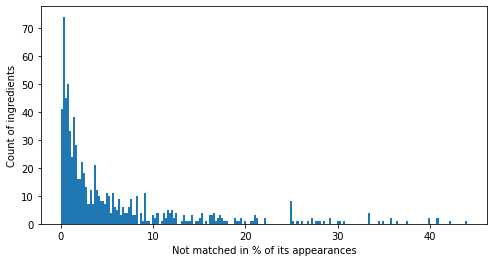

In [21]:
all_no_match_unique_2 = set(no_match_list_flat_2)

if ignore_flag == True:
    matched_df_missing_2 = matched_df2.loc[:,['recipe_id', 'no_match_after_ignore']]
    no_match_span_df_2 = pd.concat([pd.Series(row['recipe_id'], row['no_match_after_ignore']) for _, row in tqdm(matched_df_missing_2.iterrows())]).reset_index()
    no_match_span_df_2.columns = ['missing_ingredient', 'recipe_id']
    missing_matrix_2 = pd.pivot_table(no_match_span_df_2, values='missing_ingredient', index=['recipe_id'], columns=['missing_ingredient'], aggfunc=lambda x: len(x))
    missing_matrix_2 = missing_matrix_2.fillna(0)
    print(missing_matrix_2.shape) # row is each recipe, col is each (missing) ingre
    missing_in_num_recipes_2 = [(col, col_sum) for col, col_sum in missing_matrix_2.sum().iteritems()]
    missing_pct_2 = [(col, (col_sum / dict_cluster_count_ignore[col])*100) for (col, col_sum) in missing_in_num_recipes_2]
else:    
    matched_df_missing_2 = matched_df2.loc[:,['recipe_id', 'no_match']]
    no_match_span_df_2 = pd.concat([pd.Series(row['recipe_id'], row['no_match']) for _, row in tqdm(matched_df_missing_2.iterrows())]).reset_index()
    no_match_span_df_2.columns = ['missing_ingredient', 'recipe_id']
    missing_matrix_2 = pd.pivot_table(no_match_span_df_2, values='missing_ingredient', index=['recipe_id'], columns=['missing_ingredient'], aggfunc=lambda x: len(x))
    missing_matrix_2 = missing_matrix_2.fillna(0)
    print(missing_matrix_2.shape) # row is each recipe, col is each (missing) ingre
    missing_in_num_recipes_2 = [(col, col_sum) for col, col_sum in missing_matrix_2.sum().iteritems()]
    missing_pct_2 = [(col, (col_sum / dict_cluster_count[col])*100) for (col, col_sum) in missing_in_num_recipes_2]


thres_pct = 20
print('There are', len(no_match_list), 'recipes in total.')
print('There are', len(missing_matrix_2), 'recipes with at least 1 ingredient not matched.')
print('There are', len(all_no_match_unique_2), 'unique ingredients not matched in at least 1 recipe out of',len(no_match_list),'recipes.')
print('There are', len([col for col, pct in missing_pct_2 if pct <= thres_pct]), 'unique ingredients not matched in <=', thres_pct,'% of its appearances.')
print('There are', len(all_no_match_unique_2) - len([col for col, pct in missing_pct_2 if pct <= thres_pct]), 'unique ingredients not matched in >', thres_pct,'% of its appearances.')

plt.rcParams['figure.figsize'] = [8, 4]

plt.hist([pct for col, pct in missing_pct_2], density=False, bins=200)
plt.ylabel('Count of ingredients')
plt.xlabel('Not matched in % of its appearances') ### change to pct, not matched / all it appears， sort

In [22]:
ls = [(col,pct) for col, pct in missing_pct_2 if pct > thres_pct]
ls.sort(key=lambda x:x[1], reverse = True)
ls

[('beef_part', 44.0),
 ('gumdrop', 42.10526315789473),
 ('kombu', 40.909090909090914),
 ('mixed_spice', 40.74074074074074),
 ('brioche', 40.0),
 ("confectioners'_coating", 40.0),
 ('pink_peppercorn', 37.5),
 ('monosodium_glutamate', 36.36363636363637),
 ('red_snapper', 35.714285714285715),
 ('sparkling_wine', 35.714285714285715),
 ('potato_nugget', 34.92063492063492),
 ('ghee', 34.40860215053764),
 ('anise_liqueur', 33.33333333333333),
 ('beau_monde_seasoning', 33.33333333333333),
 ('beef_tri_tip', 33.33333333333333),
 ('bottom_round_roast', 33.33333333333333),
 ('flower', 30.76923076923077),
 ('wheat_gluten', 30.18867924528302),
 ('flatbread', 30.0),
 ('vinaigrette', 29.268292682926827),
 ('french_baguette', 29.1970802919708),
 ('butter_extract', 28.57142857142857),
 ('seafood_stock', 28.000000000000004),
 ('sucanat', 27.77777777777778),
 ('candied_pineapple', 27.586206896551722),
 ('beef_dripping', 27.27272727272727),
 ('rice_vermicelli', 27.27272727272727),
 ('doughnut', 26.66666666

# Output stats file with the counts of mappings for each ingre cluster name

In [23]:
def create_stats_file(has_review_data_only_flag = True, matched_df = matched_df2):
    # Create dict to store the count of each mapping
    dict_mapping_count = copy.deepcopy(dict_ingre_mapping)

    for cluster, values in dict_mapping_count.items():
        # initialize parent count
        parent_list = values['parent']
        values['parent'] = {}
        for parent in parent_list:
            values['parent'][parent] = 0

        # initialize child count
        child_list = values['child']
        values['child'] = {}
        for child in child_list:
            values['child'][child] = 0

        # initialize synonym count
        synonym_list = values['synonym']
        values['synonym'] = {}
        for synonym in synonym_list:
            values['synonym'][synonym] = 0

        # initialize short term count
        short_list = values['short']
        values['short'] = {}
        for short in short_list:
            values['short'][short] = 0

        # initialize full match count
        values['full'] = 0

        # initialize no match count
        values['no'] = 0

    for cluster_name,_ in dict_cluster_count.items():
        if cluster_name not in dict_mapping_count.keys():
            dict_mapping_count[cluster_name]['full'] = 0
            dict_mapping_count[cluster_name]['no'] = 0
            dict_mapping_count[cluster_name]['short'] = {}
            dict_mapping_count[cluster_name]['parent'] = {}
            dict_mapping_count[cluster_name]['synonym'] = {}
            dict_mapping_count[cluster_name]['child'] = {}

    # calculate the counts
    for i in tqdm(range(0,len(matched_df2))):
        row = matched_df2.iloc[i,:]
        recipe_id = row.recipe_id

        if ((has_review_data_only_flag == True) and (row.recipe_id in recipe_id_has_review_list)) \
            or (has_review_data_only_flag == False):

            perfect_match = literal_eval(row.perfect_match)
            partial_match = literal_eval(row.partial_match)
            dict_match = row.dict_match
            no_match = row.no_match

            # count full match
            for match in perfect_match:
                dict_mapping_count[match]['full'] += 1

            # count partial match
            for match in partial_match:
                cluster_name = match[0]
                short_terms = match[1]
                for short in short_terms:
                    dict_mapping_count[cluster_name]['short'][short] += 1

            # count parent, child, synonym match
            for match in dict_match:
                cluster_name = match[0]
                matched_terms = match[1]
                parents = dict_ingre_mapping[cluster_name]['parent']
                childs = dict_ingre_mapping[cluster_name]['child']
                synonyms = dict_ingre_mapping[cluster_name]['synonym']
                for term in matched_terms:
                    if term in parents:
                        dict_mapping_count[cluster_name]['parent'][term] += 1
                    elif term in childs:
                        dict_mapping_count[cluster_name]['child'][term] += 1
                    elif term in synonyms:
                        dict_mapping_count[cluster_name]['synonym'][term] += 1
                    else:
                        print("error!")

            # count no match
            for cluster_name in no_match:
                dict_mapping_count[cluster_name]['no'] += 1
        else:
            # if the has_review_data_only_flag is True but the recipe id has no review data
            continue


    # create df storing the counts in dict_mapping_count
    cluster_name_list = []
    cluster_count_list = []
    full_match_count_list = []
    no_match_count_list = []
    partial_match_count_list = []
    partial_match_total_list = []
    parent_match_count_list = []
    parent_match_total_list = []
    child_match_count_list = []
    child_match_total_list = []
    synonym_match_count_list = []
    synonym_match_total_list = []

    for cluster_name, values in dict_mapping_count.items():
        cluster_name_list.append(cluster_name)
        
        if has_review_data_only_flag == True:
            cluster_count_list.append(dict_cluster_count_has_review[cluster_name])
        else:
            cluster_count_list.append(dict_cluster_count[cluster_name])
        full_match_count_list.append(values['full'])
        no_match_count_list.append(values['no'])

        partial_matches = values['short']
        parent_matches = values['parent']
        child_matches = values['child']
        synonym_matches = values['synonym']

        partial_match_total = 0
        parent_match_total = 0
        child_match_total = 0
        synonym_match_total = 0

        partial_matches_this_cluster = []
        for term, value in partial_matches.items():
            partial_matches_this_cluster.append([term, value])
            partial_match_total += value

        parent_matches_this_cluster = []
        for term, value in parent_matches.items():
            parent_matches_this_cluster.append([term, value])
            parent_match_total += value

        child_matches_this_cluster = []
        for term, value in child_matches.items():
            child_matches_this_cluster.append([term, value])
            child_match_total += value

        synonym_matches_this_cluster = []
        for term, value in synonym_matches.items():
            synonym_matches_this_cluster.append([term, value])
            synonym_match_total += value

        partial_match_count_list.append(partial_matches_this_cluster)
        parent_match_count_list.append(parent_matches_this_cluster)
        child_match_count_list.append(child_matches_this_cluster)
        synonym_match_count_list.append(synonym_matches_this_cluster)

        partial_match_total_list.append(partial_match_total)
        parent_match_total_list.append(parent_match_total)
        child_match_total_list.append(child_match_total)
        synonym_match_total_list.append(synonym_match_total)

    df_stats = pd.DataFrame({
        'cluster_name': cluster_name_list,
        'num_of_recipes': cluster_count_list,
        'full_match_stat': full_match_count_list,
        'no_match_stat': no_match_count_list,
        'partial_match': partial_match_count_list,
        'partial_match_stat': partial_match_total_list,
        'parent_match': parent_match_count_list,
        'parent_match_stat': parent_match_total_list,
        'child_match': child_match_count_list,
        'child_match_stat': child_match_total_list,
        'synonym_match': synonym_match_count_list,
        'synonym_match_stat': synonym_match_total_list,
    })
    
    return df_stats

In [24]:
# Note: Set has_review_data_only_flag true if we only want stats file for recipe data that has reviews
#       if set as false, then the stats file of all recipes will be created

df_stats = create_stats_file(has_review_data_only_flag = True, matched_df = matched_df2)
df_stats.to_csv('OUTPUT_OF_FINAL_CODE/stats_directions_match_hasReview.csv')

df_stats = create_stats_file(has_review_data_only_flag = False, matched_df = matched_df2)
df_stats.to_csv('OUTPUT_OF_FINAL_CODE/stats_directions_match_all.csv')